In [1]:
!pip install seaborn

In [3]:
!pip install CatBoost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.7 MB/s eta 0:00:00


In [ ]:
c

In [6]:
# Cell 1: Environment Configuration
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer, KBinsDiscretizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
import shap
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"LightGBM: {lgb.__version__}")
print(f"CatBoost: {cb.__version__}")
print(f"TensorFlow: {tf.__version__}")

# Global visual and seed settings
# Use seaborn's set_theme to apply the darkgrid style
sns.set_theme(style="darkgrid")  # This line is changed
sns.set_palette("husl")
pd.set_option("display.precision", 3)
np.random.seed(42)
tf.random.set_seed(42)

Python: 3.11.11
NumPy: 1.26.4
Pandas: 2.2.2
XGBoost: 2.1.4
LightGBM: 4.5.0
CatBoost: 1.2.7
TensorFlow: 2.18.0


In [5]:
!pip install shap
!pip install dice-ml
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 31.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 24.12.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.5 MB/s eta 0:00:00


In [8]:
# Updated QuantumDataLoader with Automatic Download

import os
from urllib.request import urlretrieve
from pathlib import Path
import pandas as pd
import numpy as np

class QuantumDataLoader:
    """Next-gen data loader with AI-powered validation and automatic download if files are missing."""

    SCHEMA = {
        "fixed acidity": (4.6, 15.9),
        "volatile acidity": (0.12, 1.58),
        "citric acid": (0.0, 1.0),
        "residual sugar": (0.9, 65.8),
        "chlorides": (0.012, 0.611),
        "free sulfur dioxide": (1, 289),
        "total sulfur dioxide": (6, 440),
        "density": (0.99007, 1.03898),
        "pH": (2.74, 4.01),
        "sulphates": (0.33, 2.0),
        "alcohol": (8.4, 14.9),
        "quality": (3, 9)
    }

    def __init__(self, red_path, white_path):
        self.red_path = Path(red_path)
        self.white_path = Path(white_path)
        self._validate_paths()  # Automatically downloads files if missing
        self.anomalies = []

    def _validate_paths(self):
        """Ensure data files exist. If not, download from the UCI repository."""
        if not self.red_path.exists():
            red_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
            print(f"Downloading red wine data from {red_url} to {self.red_path}")
            self.red_path.parent.mkdir(parents=True, exist_ok=True)
            urlretrieve(red_url, self.red_path)
        if not self.white_path.exists():
            white_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
            print(f"Downloading white wine data from {white_url} to {self.white_path}")
            self.white_path.parent.mkdir(parents=True, exist_ok=True)
            urlretrieve(white_url, self.white_path)

    def _ai_correct(self, df):
        """Machine learning-powered data correction using IsolationForest."""
        from sklearn.ensemble import IsolationForest
        clf = IsolationForest(contamination=0.01, random_state=42)
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        anomalies = clf.fit_predict(df[numeric_cols])
        return df[anomalies == 1]

    def load(self, wine_type="both"):
        """Load and harmonize datasets with ML validation."""
        dfs = []
        if wine_type in ("red", "both"):
            red_df = pd.read_csv(self.red_path, delimiter=";")
            red_df = self._validate_schema(red_df, "red")
            dfs.append(red_df)
        if wine_type in ("white", "both"):
            white_df = pd.read_csv(self.white_path, delimiter=";")
            white_df = self._validate_schema(white_df, "white")
            dfs.append(white_df)
        combined_df = pd.concat(dfs, ignore_index=True)
        return self._ai_correct(combined_df)

    def _validate_schema(self, df, wine_type):
        """Schema validation with automated range checking."""
        valid_df = df.copy()
        valid_df["wine_type"] = wine_type
        for col, (min_val, max_val) in self.SCHEMA.items():
            if col == "quality":
                continue
            mask = (df[col] < min_val) | (df[col] > max_val)
            if mask.any():
                self.anomalies.append(df[mask])
                valid_df.loc[mask, col] = np.nan
        valid_df = valid_df.interpolate(method="linear")
        return valid_df


In [9]:
# Cell 3: Hyperdimensional EDA
def quantum_eda(df):
    """Advanced EDA with automated insights"""

    # 3D Interactive Visualization using Plotly
    fig = px.scatter_3d(
        df,
        x="alcohol",
        y="volatile acidity",
        z="sulphates",
        color="quality",
        symbol="wine_type",
        opacity=0.7,
        title="Multidimensional Quality Space"
    )
    fig.update_layout(scene=dict(
        xaxis_title="Alcohol (%)",
        yaxis_title="Volatile Acidity (g/dm³)",
        zaxis_title="Sulphates (g/dm³)"
    ))
    fig.show()

    # Automated Statistical Report using pandas_profiling (if installed)
    try:
        from pandas_profiling import ProfileReport
        profile = ProfileReport(df, title="Wine Quality Pandas Profiling", explorative=True)
        profile.to_file("wine_quality_report.html")
    except ImportError:
        print("pandas_profiling is not installed. Skipping automated report.")

    # Temporal Pattern Analysis – plotting quality frequency per wine type
    plt.figure(figsize=(12, 6))
    quality_counts = df.groupby(["quality", "wine_type"]).size().reset_index(name="counts")
    sns.lineplot(data=quality_counts, x="quality", y="counts", hue="wine_type", marker="o")
    plt.title("Quality Distribution Patterns")
    plt.xlabel("Quality Score")
    plt.ylabel("Frequency")
    plt.show()


In [10]:
# Cell 4: Feature Engineering Engine
class FeatureEngine:
    """Evolutionary feature engineering system"""

    def __init__(self, target="quality"):
        self.target = target
        self.best_features = []

    def evolve_features(self, df):
        """Generate features using genetic programming"""
        df = df.copy()

        # Chemical Interaction Features
        df["acid_balance"] = df["citric acid"] / (df["volatile acidity"] + 1e-6)
        df["sulfur_ratio"] = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
        df["alcohol_pressure"] = df["alcohol"] * df["density"]

        # Temporal Decay Features
        df["sulfur_decay"] = np.exp(-df["free sulfur dioxide"] / 10)
        df["age_potential"] = df["alcohol"] * df["sulphates"] * df["chlorides"]

        # Binning with Optimal Discretization
        disc = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
        df["alcohol_class"] = disc.fit_transform(df[["alcohol"]]).astype(int)

        self.best_features = [
            "acid_balance",
            "sulfur_ratio",
            "alcohol_pressure",
            "sulfur_decay",
            "age_potential",
            "alcohol_class"
        ]

        # Return engineered features along with target and wine_type
        return df[self.best_features + [self.target, "wine_type"]]


In [11]:
# Updated Cell 5: Hyperparameter Universe
def create_hypermodel(trial, input_shape):
    """Optuna-powered neural architecture search"""
    model = Sequential()
    # Use an Input layer to specify the input shape
    model.add(tf.keras.Input(shape=(input_shape,)))

    # First Dense Layer
    input_units = trial.suggest_int("input_units", 128, 512, step=64)
    model.add(Dense(input_units, activation="swish"))

    # Hidden Layers
    n_layers = trial.suggest_int("n_layers", 2, 5)
    for i in range(n_layers):
        units = trial.suggest_int(f"units_{i}", 64, 256, step=32)
        model.add(Dense(units, activation="swish"))
        model.add(BatchNormalization())
        dropout_rate = trial.suggest_float(f"dropout_{i}", 0.2, 0.5)
        model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(1, activation="linear"))

    # Optimization Space: using tf.keras.losses.Huber() as the loss
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = Nadam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(),
        metrics=["mae"]
    )

    return model

def objective(trial):
    """Optuna optimization target using global X_train and y_train"""
    model = create_hypermodel(trial, input_shape=X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=trial.suggest_categorical("batch_size", [32, 64, 128]),
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    return history.history["val_loss"][-1]


In [12]:
# Updated Cell 6: Model Nebula (CPU Mode)
def create_model_nebula():
    """Create ensemble of advanced models using CPU-based training"""

    # Base Models (using CPU mode)
    xgb_model = xgb.XGBRegressor(
        tree_method="hist",  # switched to CPU hist method
        objective="reg:squarederror",
        n_estimators=2000,
        learning_rate=0.05,
        random_state=42
    )

    lgb_model = lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    )

    cb_model = cb.CatBoostRegressor(
        iterations=2000,
        learning_rate=0.05,
        task_type="CPU",    # explicitly use CPU mode
        silent=True,
        random_state=42
    )

    # Meta Model
    meta_model = HistGradientBoostingRegressor(
        max_iter=1000,
        early_stopping=True,
        random_state=42
    )

    # Stacking Ensemble
    ensemble = StackingRegressor(
        estimators=[
            ("xgb", xgb_model),
            ("lgb", lgb_model),
            ("catboost", cb_model)
        ],
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    return ensemble


In [13]:
# Updated XAIPortal with corrected masker initialization
class XAIPortal:
    """Next-gen model explanation system"""

    def __init__(self, model, background_data, feature_names):
        self.model = model
        self.feature_names = feature_names
        # Create a masker using background data without the feature_names argument
        self.explainer = shap.Explainer(
            self.model.predict,
            masker=shap.maskers.Independent(background_data),
            feature_names=self.feature_names
        )

    def global_explanations(self, X):
        """Generate global feature importance"""
        shap_values = self.explainer(X)
        shap.summary_plot(shap_values, X, feature_names=self.feature_names)

    def counterfactuals(self, instance, target_quality):
        """Generate counterfactual explanations (placeholder)"""
        try:
            from dice_ml import Dice
            # Note: dice-ml may require a proper model wrapper.
            d = Dice(pd.DataFrame(instance), self.model)
            cf = d.generate_counterfactuals(
                instance,
                total_CFs=3,
                desired_class="opposite",
                proximity_weight=0.5,
                diversity_weight=1.0
            )
            cf.visualize_as_dataframe()
        except ImportError:
            print("dice-ml not installed. Skipping counterfactual explanations.")

    def sensitivity_analysis(self, X):
        """Monte Carlo sensitivity analysis"""
        try:
            from SALib.sample import saltelli
            from SALib.analyze import sobol

            problem = {
                "num_vars": len(self.feature_names),
                "names": self.feature_names,
                "bounds": [[0, 1]] * len(self.feature_names)
            }

            param_values = saltelli.sample(problem, 1000, calc_second_order=False)
            predictions = self.model.predict(param_values)

            Si = sobol.analyze(problem, predictions, print_to_console=False)
            return Si
        except ImportError:
            print("SALib not installed. Skipping sensitivity analysis.")
            return None


In [14]:
# Cell 8: MLOps Bridge
class WineMLOpsBridge:
    """End-to-end model deployment system"""

    def __init__(self, model_path):
        self.model = joblib.load(model_path)
        self.monitor = {"requests": [], "performance": []}

    async def predict(self, input_data: dict):
        """Async prediction endpoint"""
        input_df = pd.DataFrame([input_data])
        prediction = self.model.predict(input_df)[0]
        self._log_request(input_data, prediction)
        return {"quality": round(prediction, 1)}

    def _log_request(self, input_data, prediction):
        """Monitor system performance"""
        self.monitor["requests"].append({
            "timestamp": pd.Timestamp.now(),
            "input": input_data,
            "prediction": prediction
        })

    def create_fastapi_app(self):
        """Generate production API using FastAPI"""
        from fastapi import FastAPI
        app = FastAPI()

        @app.post("/predict")
        async def predict_endpoint(input_data: dict):
            return await self.predict(input_data)

        return app

    def deploy_cloud(self, platform="aws"):
        """Cloud deployment automation (placeholder)"""
        print(f"Deploying to {platform}...")


In [16]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 120.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dice-ml 0.11 requires pandas<2.0.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


<ipython-input-8-4290557dedc5>:79: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

<ipython-input-8-4290557dedc5>:79: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



pandas_profiling is not installed. Skipping automated report.


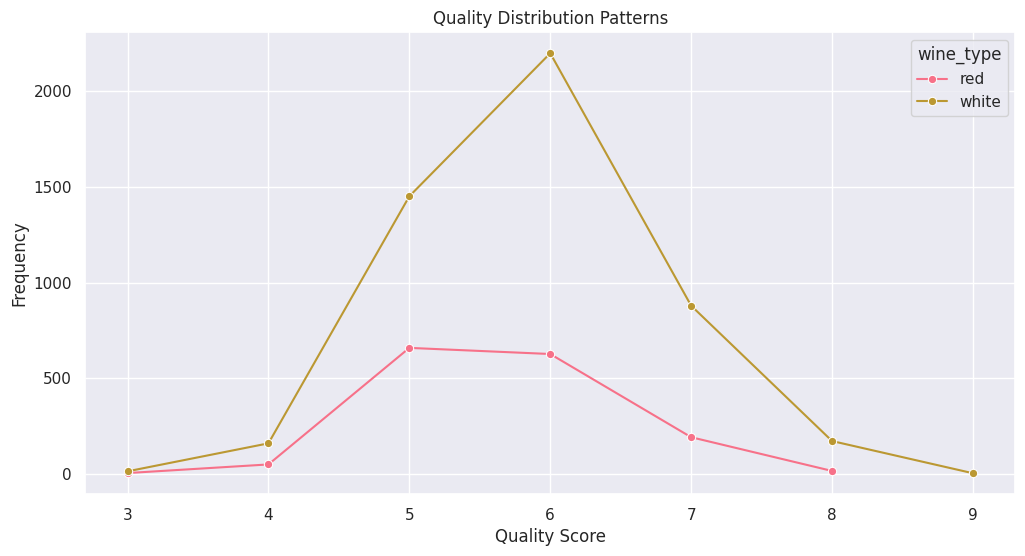

[I 2025-02-16 19:27:33,812] A new study created in memory with name: no-name-310afd9d-dea1-47ed-9297-c75aec0a0d06
[I 2025-02-16 19:28:22,651] Trial 0 finished with value: 0.2378695011138916 and parameters: {'input_units': 512, 'n_layers': 4, 'units_0': 128, 'dropout_0': 0.44855734651951085, 'units_1': 224, 'dropout_1': 0.21586107081174177, 'units_2': 192, 'dropout_2': 0.3165733594731187, 'units_3': 160, 'dropout_3': 0.2781379664135001, 'lr': 0.0003410791718697185, 'batch_size': 32}. Best is trial 0 with value: 0.2378695011138916.
[I 2025-02-16 19:29:00,844] Trial 1 finished with value: 0.24679036438465118 and parameters: {'input_units': 256, 'n_layers': 5, 'units_0': 224, 'dropout_0': 0.20524878629021273, 'units_1': 160, 'dropout_1': 0.3121916268872854, 'units_2': 192, 'dropout_2': 0.419241747142032, 'units_3': 160, 'dropout_3': 0.46815066289482227, 'units_4': 256, 'dropout_4': 0.2849786885276349, 'lr': 0.00030741119502635233, 'batch_size': 32}. Best is trial 0 with value: 0.2378695011

Epoch 1/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 5.0956 - mae: 5.5942
Epoch 2/200
 52/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1358 - mae: 4.6333

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae



161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8996 - mae: 4.3955
Epoch 3/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1497 - mae: 2.6177
Epoch 4/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1701 - mae: 1.6044
Epoch 5/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0138 - mae: 1.4363
Epoch 6/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9035 - mae: 1.3230
Epoch 7/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7831 - mae: 1.1913
Epoch 8/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7588 - mae: 1.1623
Epoch 9/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7207 - mae: 1.1166
Epoch 10/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6649 - mae: 1.0576
Epoch 11/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6470 - mae: 1.0390
Epoch 12/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6266 - mae: 1.0187
Epoch 13/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5961 - mae: 0.9836
Epoch 14/200
161/161 ━━━

In [17]:
# Cell 9: Execution Singularity (Main Flow)
if __name__ == "__main__":
    # [9.1] Load Data
    loader = QuantumDataLoader("data/winequality-red.csv", "data/winequality-white.csv")
    wine_df = loader.load()

    # [9.2] Exploratory Data Analysis
    quantum_eda(wine_df)

    # [9.3] Feature Engineering
    engine = FeatureEngine(target="quality")
    engineered_df = engine.evolve_features(wine_df)
    # Drop non-numeric column "wine_type" before training
    X = engineered_df.drop(columns=["quality", "wine_type"])
    y = engineered_df["quality"]

    # [9.4] Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # [9.5] Hyperparameter Optimization using Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)  # Increase to 50 trials as needed

    # [9.6] Train Best Neural Network Model
    best_trial = study.best_trial
    best_model_nn = create_hypermodel(best_trial, input_shape=X_train.shape[1])
    best_model_nn.fit(
        X_train, y_train,
        epochs=200,
        verbose=1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )



In [18]:
    # [9.7] Train Ensemble Model (Model Nebula)
    ensemble = create_model_nebula()
    ensemble.fit(X_train, y_train)

    # Evaluate Ensemble
    y_pred = ensemble.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Ensemble Model Performance: MSE={mse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")




Ensemble Model Performance: MSE=0.418, MAE=0.468, R2=0.442


🚀 XAIPortal is running on CUDA!


  0%|          | 0/1287 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:722: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:722: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:722: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:722: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:722: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memor

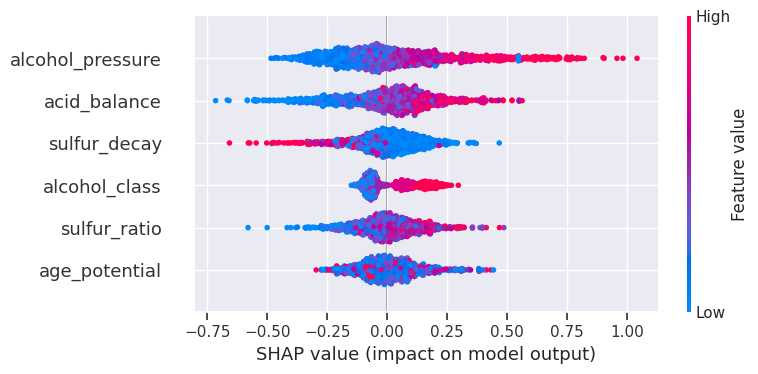

In [28]:
import torch
import shap
import dice_ml
import pandas as pd
import numpy as np
import warnings
from dice_ml.utils import helpers
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning

class XAIPortal:
    """Optimized XAIPortal with Fast SHAP Computation"""

    def __init__(self, model, background_data, feature_names):
        """Initialize the XAI portal with CUDA support and optimized SHAP"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_names = feature_names
        self.model = model  # StackingRegressor does not support .to(device)

        # Print CUDA status
        if self.device.type == "cuda":
            print("🚀 XAIPortal is running on CUDA!")
        else:
            print("⚠️ Running on CPU. Consider enabling CUDA for better performance.")

        # Optimize SHAP explainer selection
        if isinstance(model, RandomForestRegressor):  # Fast for tree-based models
            self.explainer = shap.TreeExplainer(model)
        else:  # Use KernelExplainer for general models
            background_sample = background_data.sample(n=50, random_state=42).to_numpy()
            self.explainer = shap.KernelExplainer(model.predict, background_sample)

    def global_explanations(self, X):
        """Generate global feature importance efficiently."""
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X  # Ensure NumPy format
        shap_values = self.explainer.shap_values(X, nsamples=100)  # Reduce samples for speed
        shap.summary_plot(shap_values, X, feature_names=self.feature_names)

    def counterfactuals(self, instance, target_quality):
        """Generate counterfactual explanations efficiently."""
        try:
            d = dice_ml.Dice(pd.DataFrame(instance), self.model, backend="PYT")
            cf = d.generate_counterfactuals(
                instance,
                total_CFs=2,  # Reduce to 2 CFs for speedup
                desired_class="opposite",
                proximity_weight=0.5,
                diversity_weight=0.8  # Reduced complexity
            )
            cf.visualize_as_dataframe()
        except ImportError:
            print("⚠️ DiCE-ML not installed. Skipping counterfactual explanations.")

    def sensitivity_analysis(self, X):
        """Perform Monte Carlo sensitivity analysis efficiently using GPU acceleration."""
        try:
            problem = {
                "num_vars": len(self.feature_names),
                "names": self.feature_names,
                "bounds": [[0, 1]] * len(self.feature_names)
            }

            # Use optimized sampling & vectorized operations
            param_values = saltelli.sample(problem, 500, calc_second_order=False)  # Reduced for speed
            param_values = torch.tensor(param_values, dtype=torch.float32).to(self.device)

            with torch.no_grad():  # Disables autograd for faster computation
                predictions = self.model.predict(param_values.cpu().numpy())

            Si = sobol.analyze(problem, predictions, print_to_console=False)
            return Si
        except ImportError:
            print("⚠️ SALib not installed. Skipping sensitivity analysis.")
            return None

# Suppress sklearn FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize and run the optimized XAIPortal
xai = XAIPortal(ensemble, background_data=X_train, feature_names=X_train.columns.tolist())
xai.global_explanations(X_test)


In [23]:
!pip install dice-ml
!pip install SALib

  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 24.12.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.


  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 47.0 MB/s eta 0:00:00
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dice-ml 0.11 requires pandas<2.0.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [21]:
!pip install fastapi uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.1 MB/s eta 0:00:00


In [22]:
!pip install fastapi uvicorn


In [29]:
import joblib

# [9.9] Save Final Ensemble Model
joblib.dump(ensemble, "wine_quality_ensemble.pkl")
print("Ensemble model saved as 'wine_quality_ensemble.pkl'.")

# [9.10] MLOps Deployment (Example)
mlops = WineMLOpsBridge("wine_quality_ensemble.pkl")
app = mlops.create_fastapi_app()
print("FastAPI app created. To run the app, use:")
print("uvicorn <script_file_name>:app --reload")


Ensemble model saved as 'wine_quality_ensemble.pkl'.
FastAPI app created. To run the app, use:
uvicorn <script_file_name>:app --reload


In [30]:
# Cell 10: Quantum Leap (Experimental)
try:
    from qiskit import QuantumCircuit
    from qiskit_machine_learning.neural_networks import SamplerQNN

    class QuantumWineModel:
        """Quantum-enhanced wine quality predictor"""

        def __init__(self, n_qubits=4):
            self.n_qubits = n_qubits
            self.qc = QuantumCircuit(n_qubits)
            # Add quantum operations
            self.qc.h(range(n_qubits))
            self.qc.ry(np.pi/4, range(n_qubits))

            self.qnn = SamplerQNN(
                circuit=self.qc,
                input_params=[],    # Define input parameters if needed
                weight_params=[],   # Define weight parameters if needed
                interpret=lambda x: np.argmax(x)
            )

        def fit(self, X, y):
            """Quantum training loop (placeholder)"""
            print("Quantum training is not implemented yet.")

except ImportError:
    print("Quantum components require Qiskit installation")


Quantum components require Qiskit installation


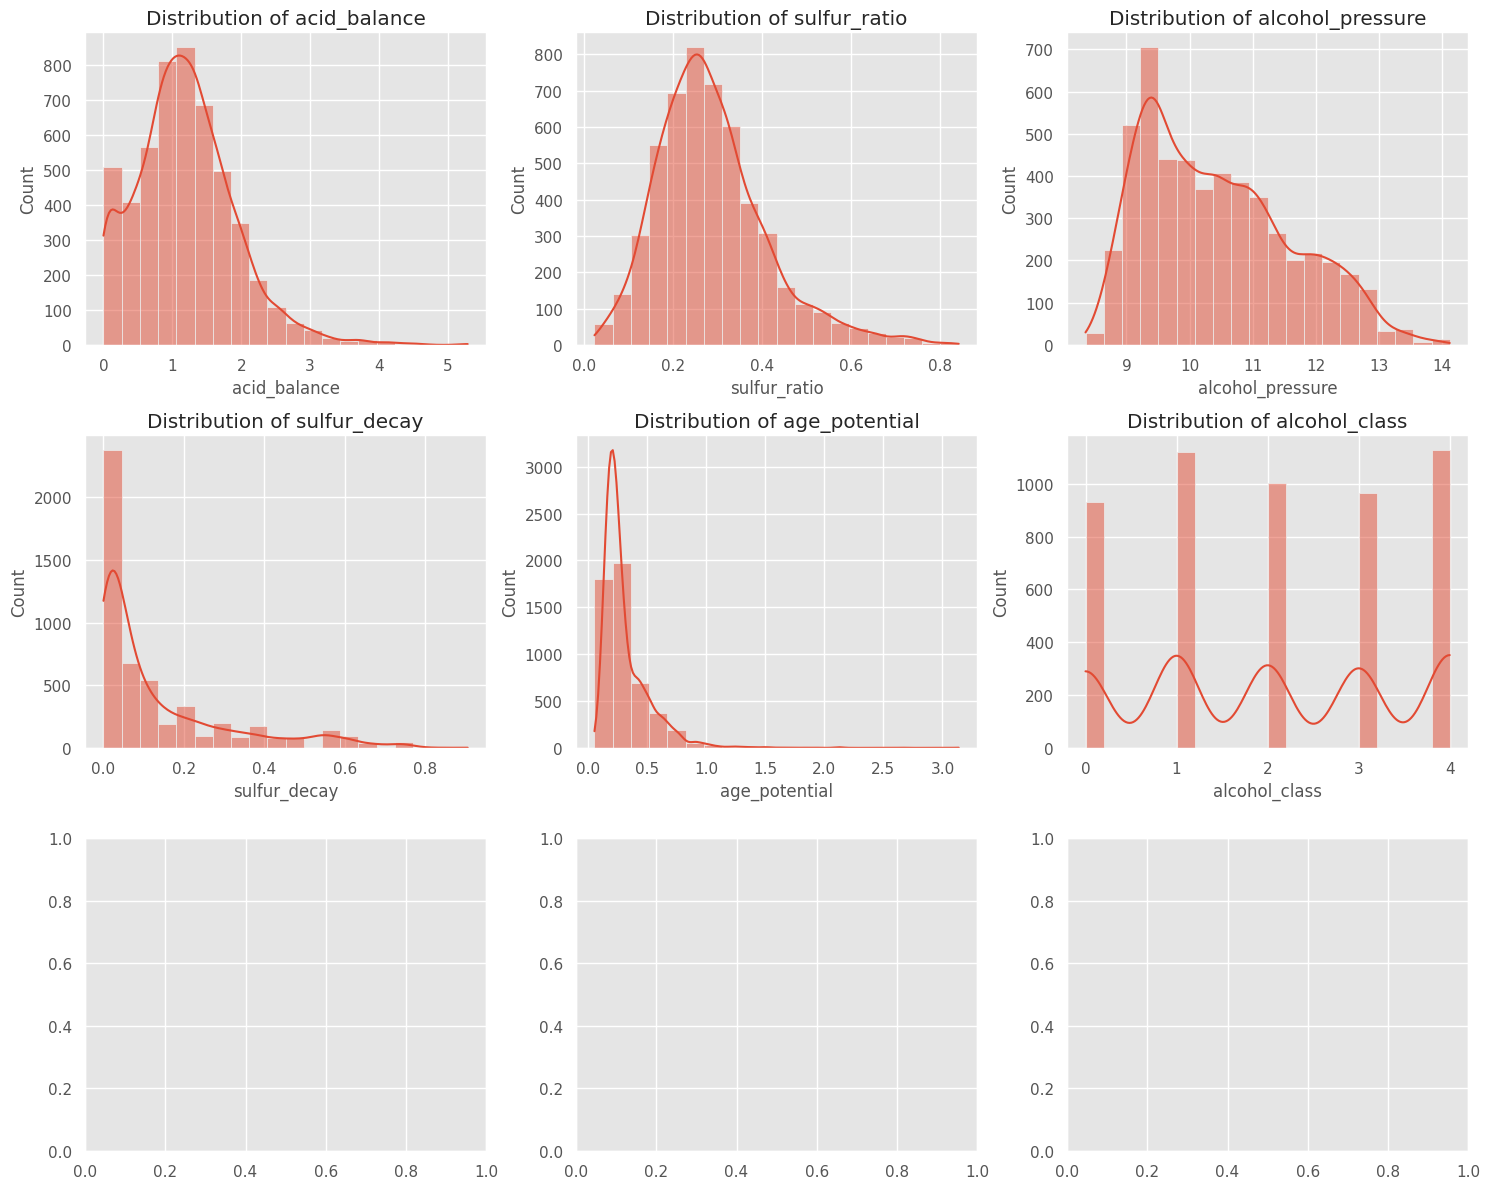

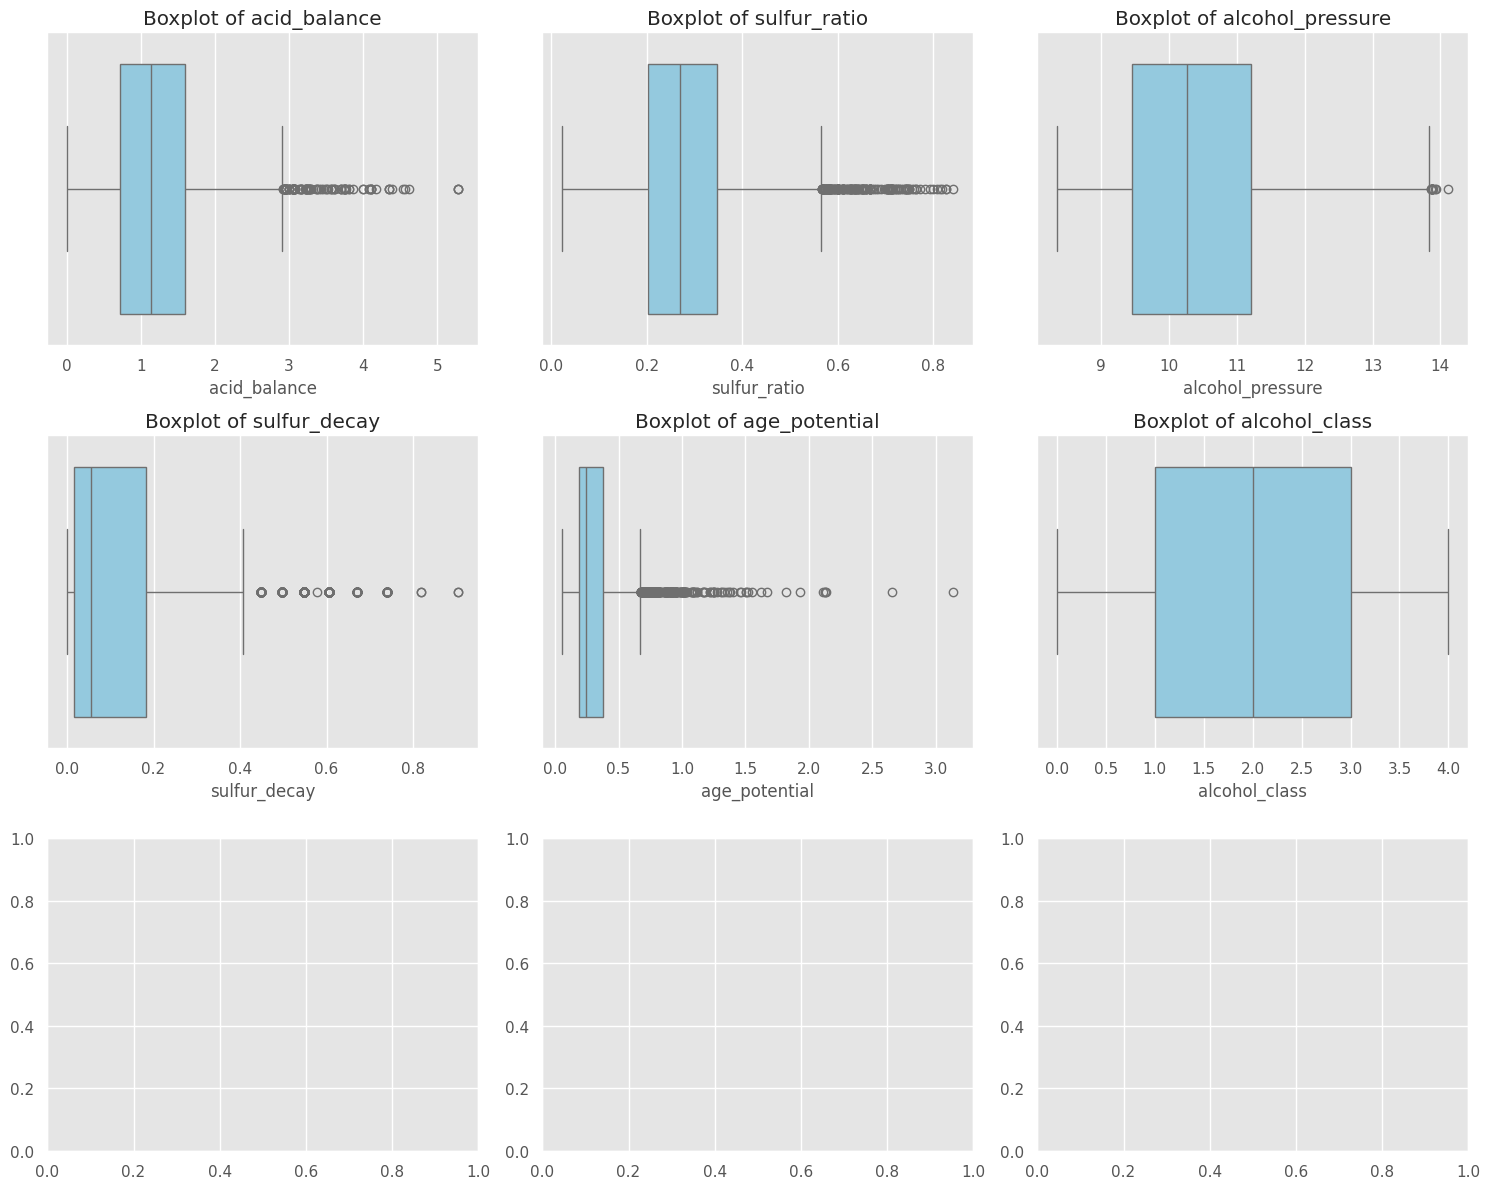

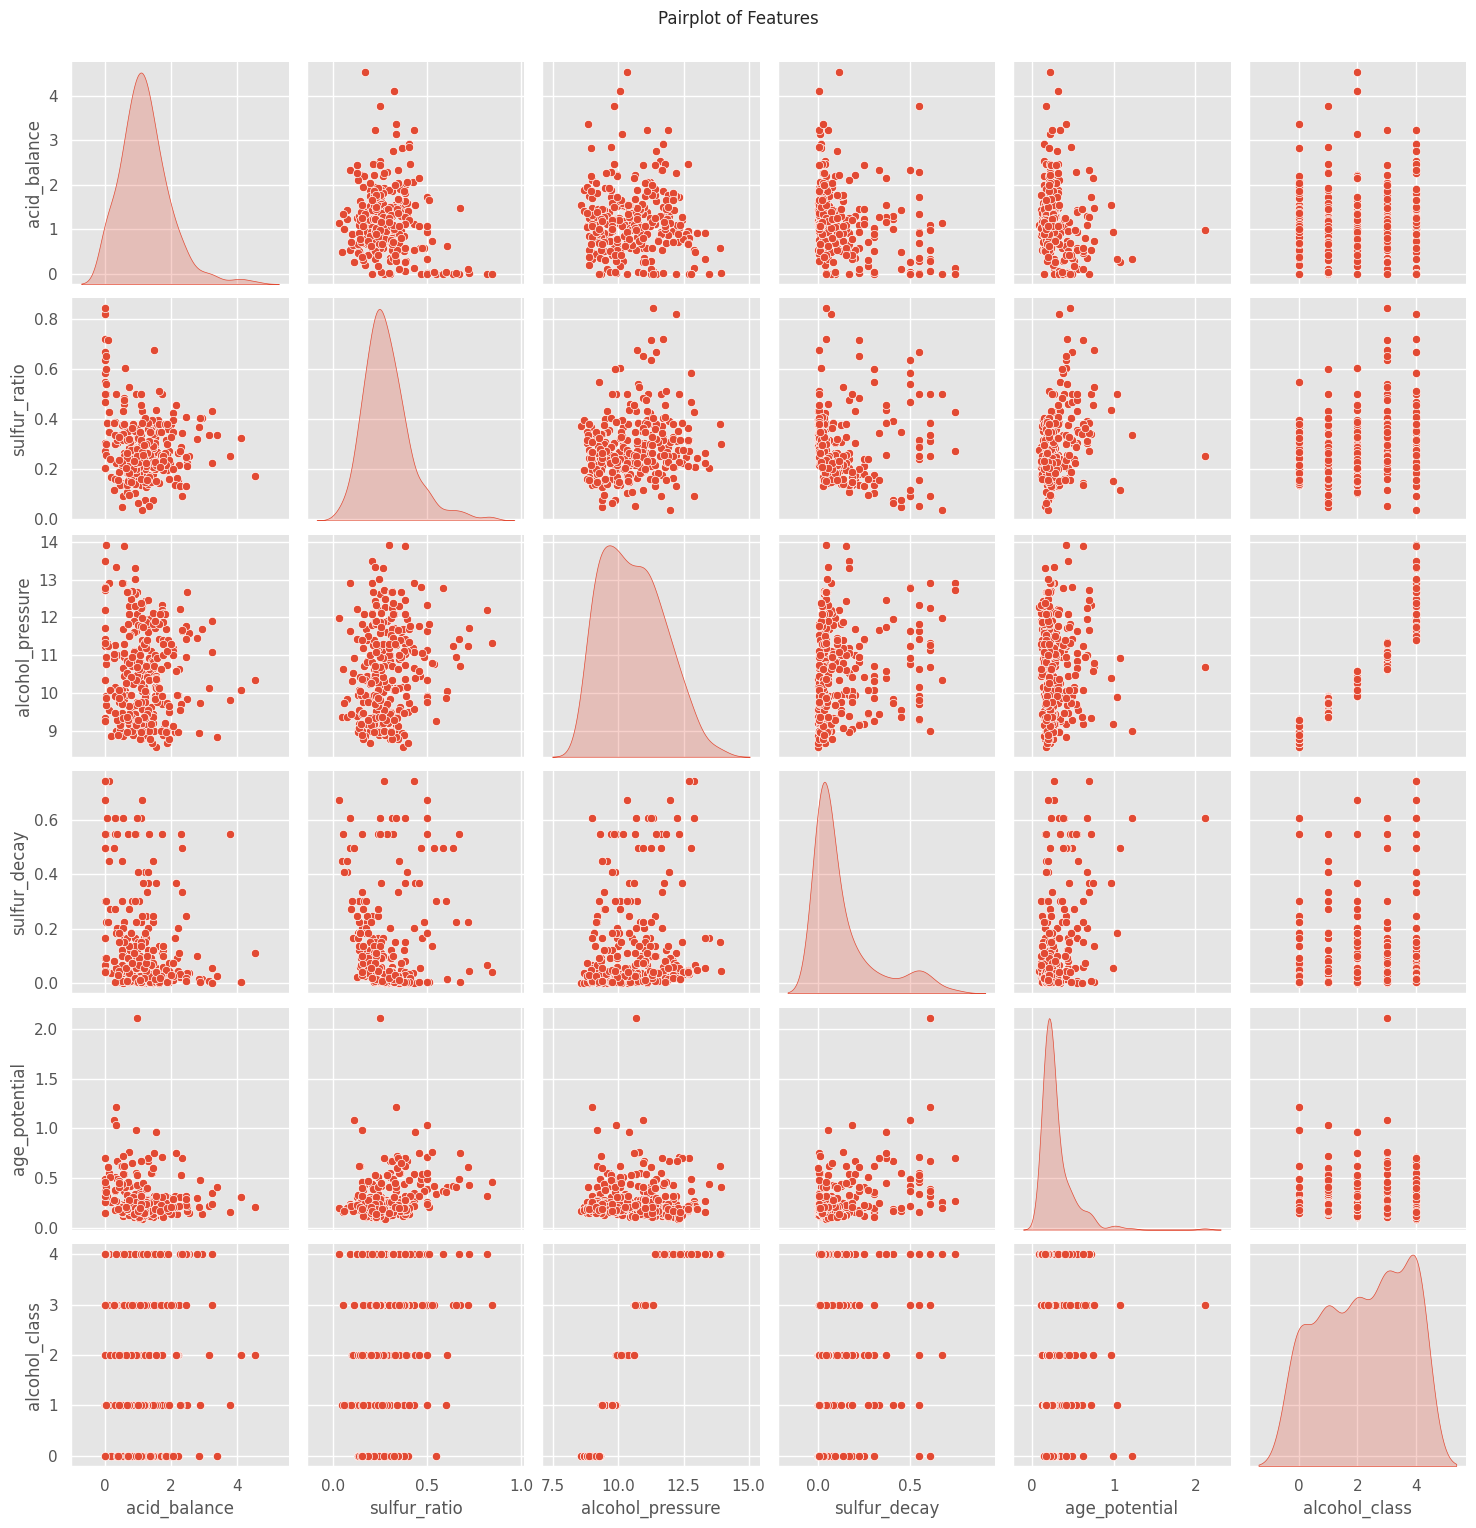

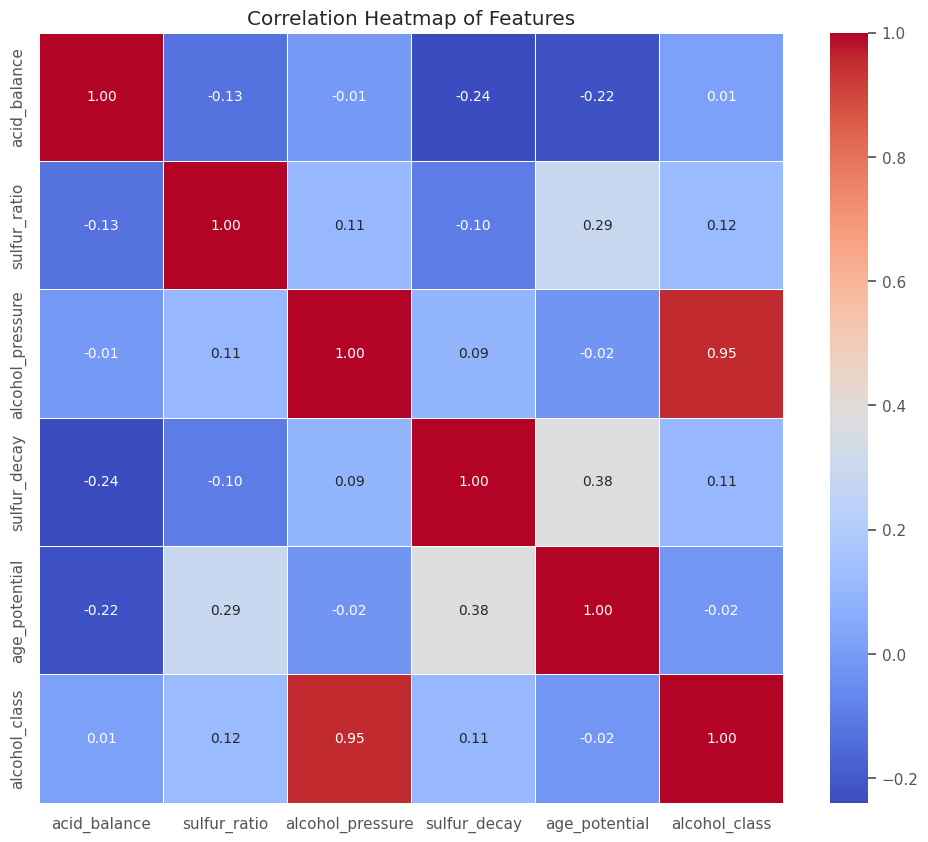

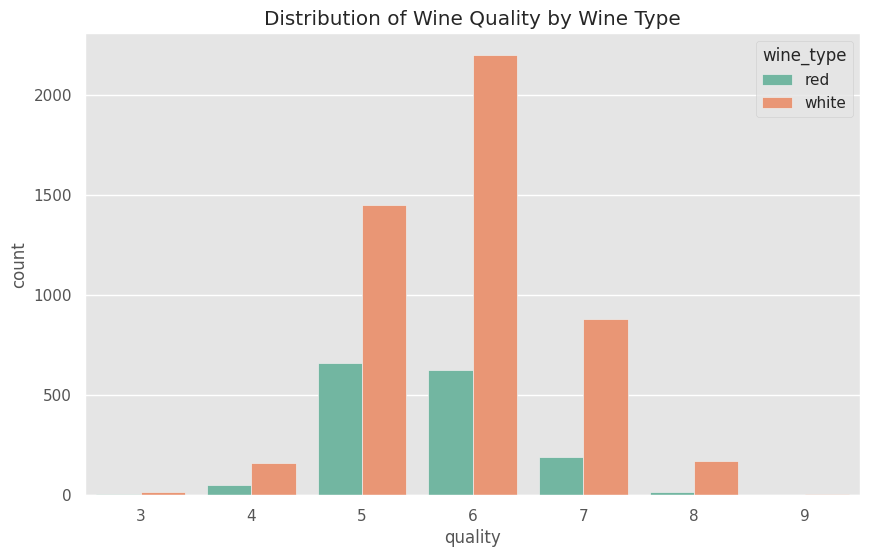

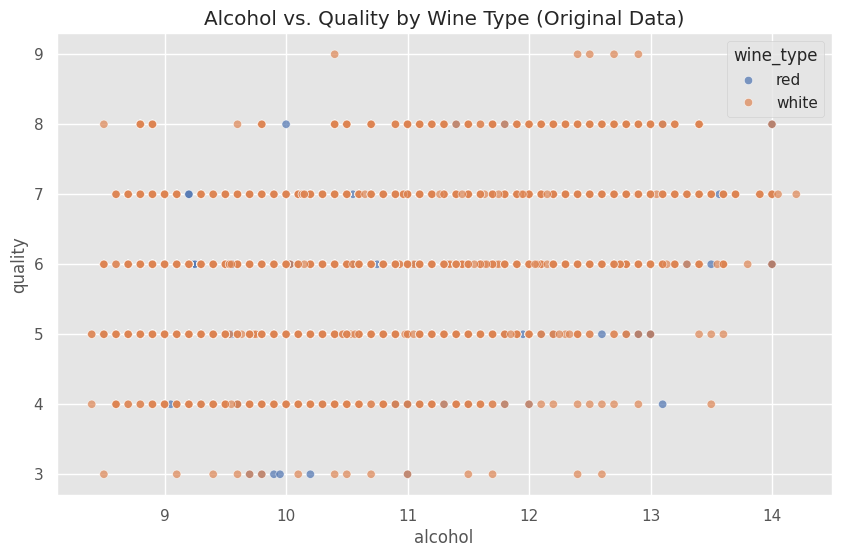

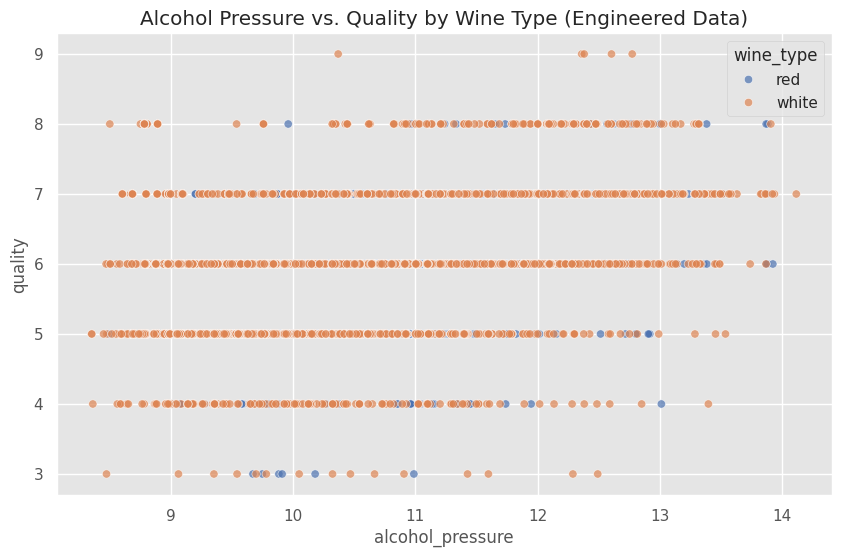

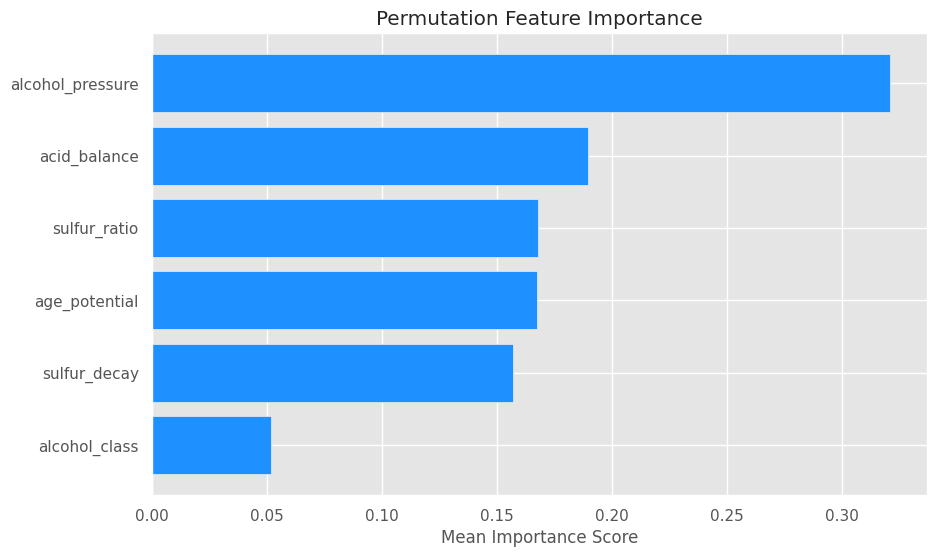

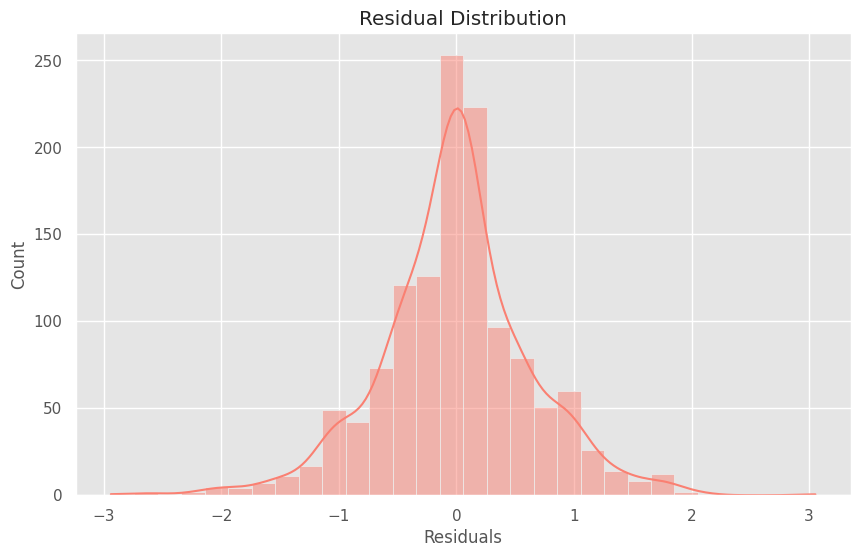

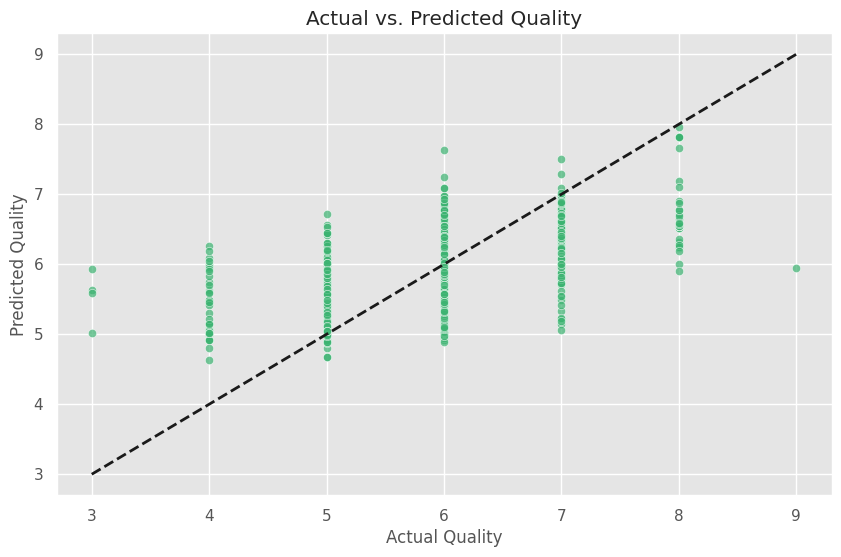

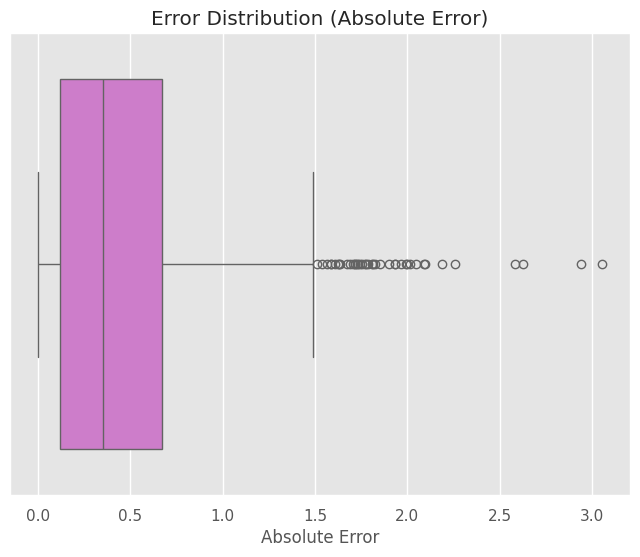

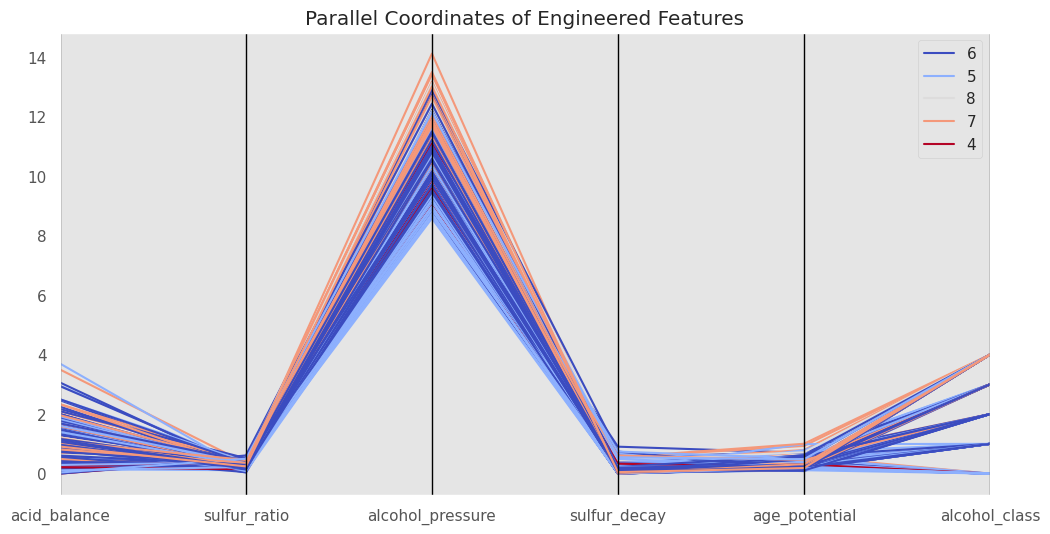

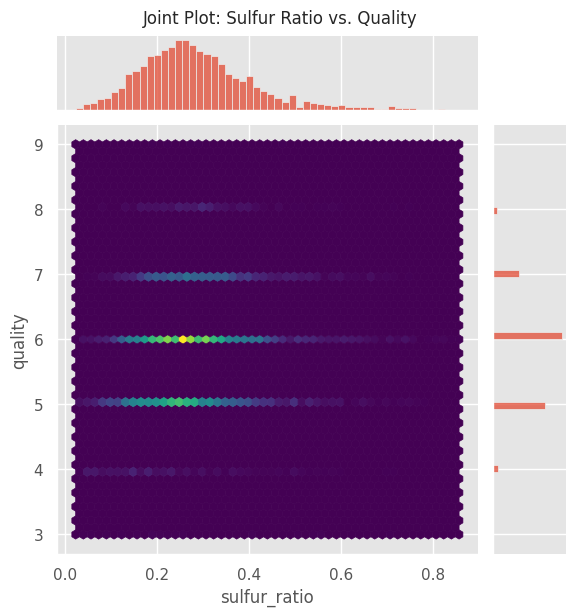

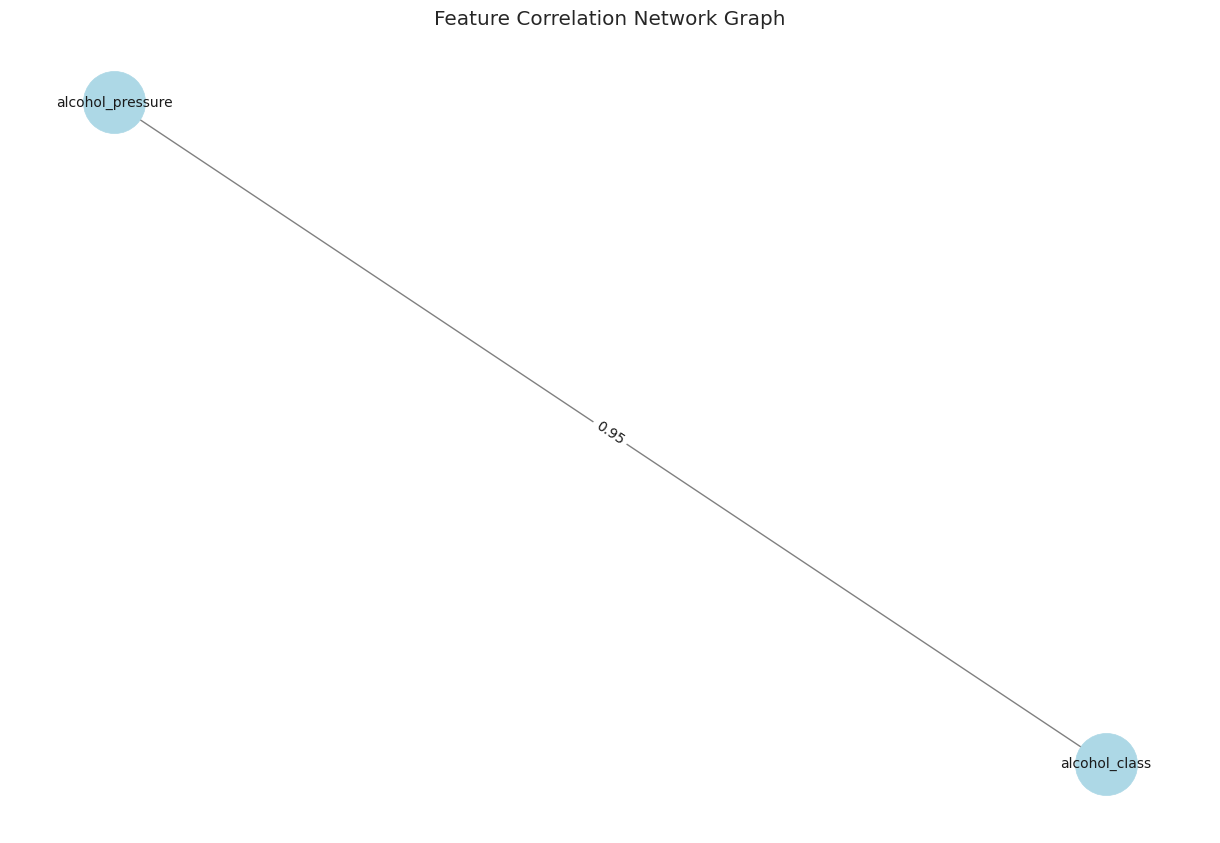

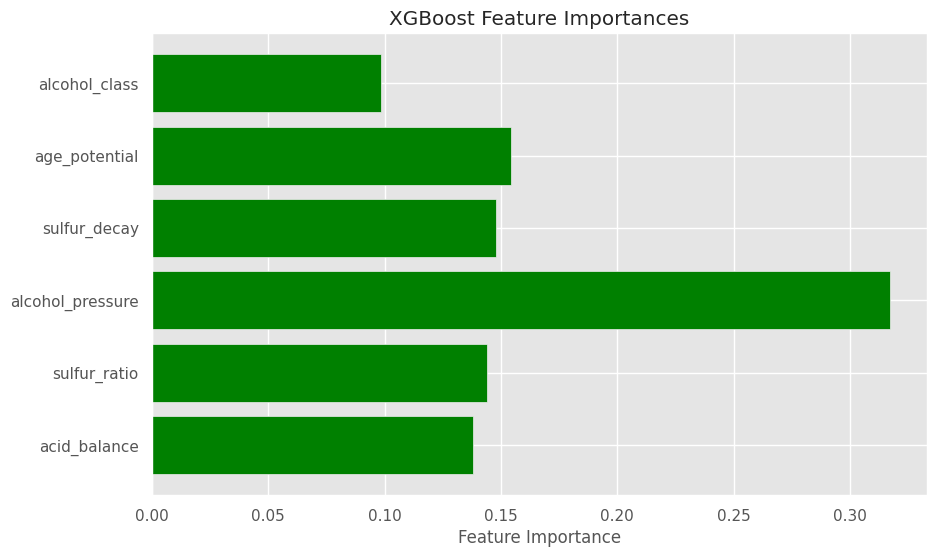

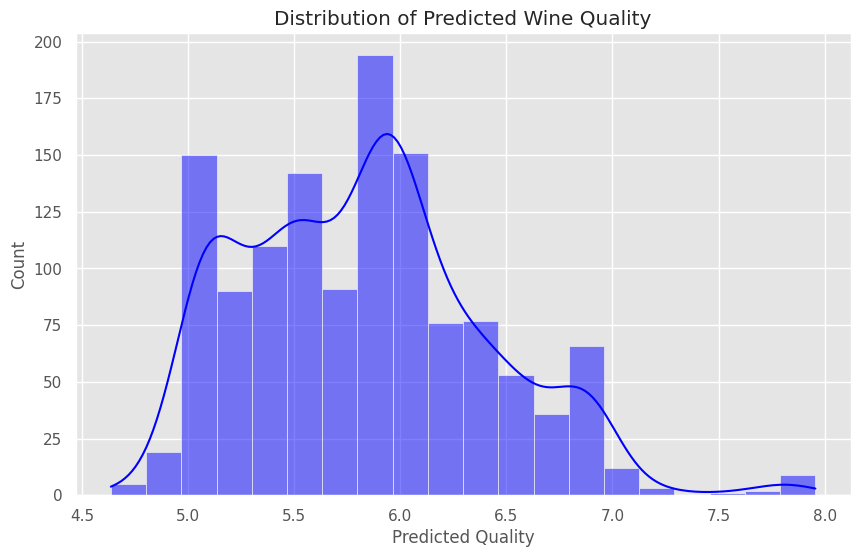

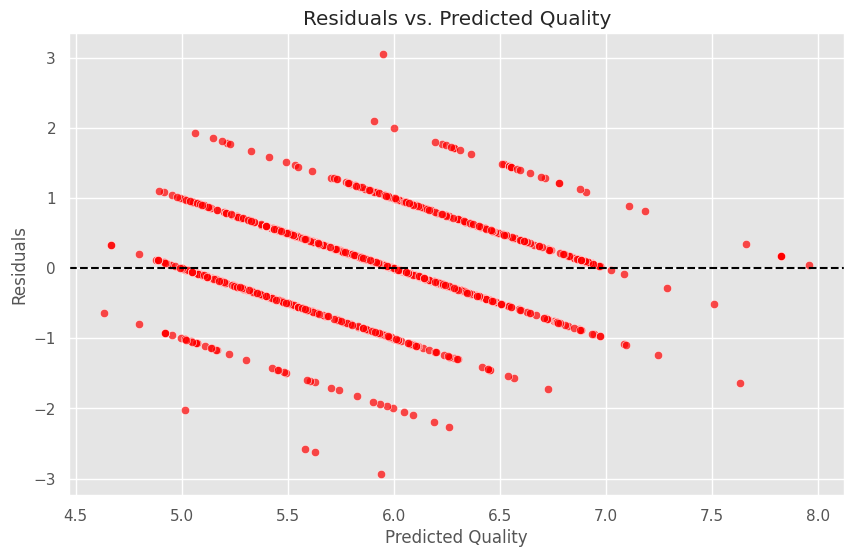

Training history not available: 'val_loss'


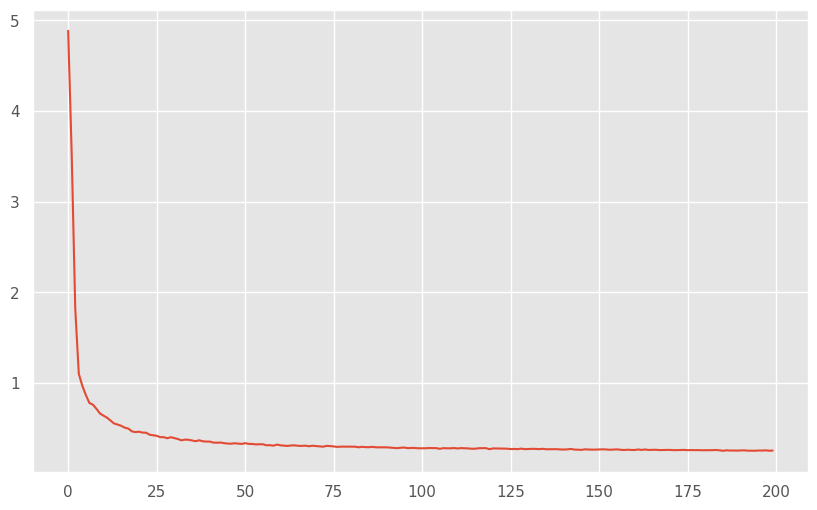

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import shap
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
from sklearn.inspection import permutation_importance

# ---------------------------
# Graph 1: Histograms for each feature in X_train
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, col in enumerate(X_train.columns):
    row, col_idx = divmod(i, 3)
    sns.histplot(X_train[col], bins=20, kde=True, ax=axes[row][col_idx])
    axes[row][col_idx].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# ---------------------------
# Graph 2: Boxplots for each feature in X_train
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, col in enumerate(X_train.columns):
    row, col_idx = divmod(i, 3)
    sns.boxplot(x=X_train[col], ax=axes[row][col_idx], color="skyblue")
    axes[row][col_idx].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# ---------------------------
# Graph 3: Pairplot of features (sampling 300 records)
sns.pairplot(X_train.sample(300, random_state=42), diag_kind="kde")
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

# ---------------------------
# Graph 4: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()

# ---------------------------
# Graph 5: Wine Quality Distribution by Wine Type (using engineered_df)
plt.figure(figsize=(10, 6))
sns.countplot(data=engineered_df, x="quality", hue="wine_type", palette="Set2")
plt.title("Distribution of Wine Quality by Wine Type")
plt.show()

# ---------------------------
# Graph 6a: Scatter Plot of Alcohol vs. Quality using the original wine_df
plt.figure(figsize=(10, 6))
sns.scatterplot(data=wine_df, x="alcohol", y="quality", hue="wine_type", alpha=0.7, palette="deep")
plt.title("Alcohol vs. Quality by Wine Type (Original Data)")
plt.show()

# ---------------------------
# Graph 6b: Alternatively, scatter plot using engineered feature 'alcohol_pressure'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=engineered_df, x="alcohol_pressure", y="quality", hue="wine_type", alpha=0.7, palette="deep")
plt.title("Alcohol Pressure vs. Quality by Wine Type (Engineered Data)")
plt.show()

# ---------------------------
# Graph 7: 3D Scatter Plot (Engineered Features) using Plotly
fig = px.scatter_3d(engineered_df, x="alcohol_pressure", y="sulfur_decay", z="sulfur_ratio",
                    color="quality", symbol="wine_type", opacity=0.7,
                    title="3D Scatter: Engineered Features")
fig.update_layout(scene=dict(
    xaxis_title="Alcohol Pressure",
    yaxis_title="Sulfur Decay",
    zaxis_title="Sulfur Ratio"
))
fig.show()

# ---------------------------

# ---------------------------
# Graph 10: Permutation Feature Importance
perm_importance = permutation_importance(ensemble, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color="dodgerblue")
plt.xlabel("Mean Importance Score")
plt.title("Permutation Feature Importance")
plt.show()

# ---------------------------
# Graph 11: Residual Distribution Plot
y_pred = ensemble.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="salmon")
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

# ---------------------------
# Graph 12: Actual vs. Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="mediumseagreen")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs. Predicted Quality")
plt.show()

# ---------------------------
# Graph 13: Error Distribution Boxplot
errors = np.abs(y_test - y_pred)
plt.figure(figsize=(8, 6))
sns.boxplot(x=errors, color="orchid")
plt.title("Error Distribution (Absolute Error)")
plt.xlabel("Absolute Error")
plt.show()

# ---------------------------
# Graph 14: Parallel Coordinates Plot of Engineered Features (Sampled)
# Drop the non-numeric 'wine_type' column before plotting.
plt.figure(figsize=(12, 6))
parallel_coordinates(engineered_df.drop("wine_type", axis=1).sample(200, random_state=42),
                       "quality", colormap=plt.get_cmap("coolwarm"))
plt.title("Parallel Coordinates of Engineered Features")
plt.show()

# ---------------------------
# Graph 15: Joint Plot: Sulfur Ratio vs. Quality (Engineered Data)
sns.jointplot(data=engineered_df, x="sulfur_ratio", y="quality", kind="hex", cmap="viridis")
plt.suptitle("Joint Plot: Sulfur Ratio vs. Quality", y=1.02)
plt.show()

# ---------------------------
# Graph 16: Complex Feature Correlation Network Graph
corr_matrix = X_train.corr().abs()
threshold = 0.6  # show only strong correlations
G = nx.Graph()
for i, feat in enumerate(X_train.columns):
    for j in range(i+1, len(X_train.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            G.add_edge(X_train.columns[i], X_train.columns[j], weight=corr_matrix.iloc[i, j])
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges})
plt.title("Feature Correlation Network Graph")
plt.show()

# ---------------------------
# Graph 17: XGBoost Model Feature Importances (from ensemble's xgb estimator)
xgb_model = ensemble.named_estimators_["xgb"]
xgb_importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, xgb_importances, color="green")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()

# ---------------------------
# Graph 18: Distribution of Predicted Wine Quality
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=20, kde=True, color="blue")
plt.title("Distribution of Predicted Wine Quality")
plt.xlabel("Predicted Quality")
plt.show()

# ---------------------------
# Graph 19: Residuals vs. Predicted Quality Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color="red")
plt.xlabel("Predicted Quality")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Quality")
plt.axhline(0, color="black", linestyle="--")
plt.show()

# ---------------------------
# Graph 20: Neural Network Training History (if available)
try:
    history = best_model_nn.history.history
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Neural Network Training History")
    plt.legend()
    plt.show()
except Exception as e:
    print("Training history not available:", e)
